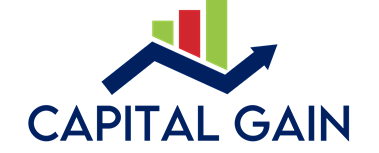
### ADMN5006: Financial Analytics
#### Final Project
Asharani Sukumaran Nair, Donovan Bangs, Maria Isabel Dio Grau, Xiuhao Shuai

***

### Table of Contents

<a href='#historical'>Historical Stock Performance</a><br>
<a href='#ratios'>Financial Ratios</a><br>
<a href='#corr'>Correlation and Covariance</a><br>
<a href='#montecarlo'>Monte Carlo Simulation</a><br>
<a href='#portfolio'>Portfolio Optimization</a><br>
<a href='#scenario'>Scenario Analysis</a><br>

In [56]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import yfinance as yf
yf.pdr_override()
import math
from scipy.stats import norm
import seaborn
import seaborn as sns
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Setup

stocks = ['NVDA', 'ABBV', 'TTE', 'LUV']
N = 252 # Number of trading days
rf = 0.00833 #13-week US T-Bill rate as of April 26, 2022 (Yahoo Finance: ^IRX)


In [3]:
startdate = datetime(2013,1,1)
enddate = datetime(2019,12,31)

In [4]:
table = pdr.get_data_yahoo(stocks, data_source = 'yahoo', start = startdate, end = enddate)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [5]:
table.head()

,ABBV,LUV,NVDA,TTE
Date,,,,
2013-01-02,23.783302,9.779123,2.939527,30.516874
2013-01-03,23.586918,10.012627,2.941838,30.290489
2013-01-04,23.288942,10.162074,3.038897,30.365942
2013-01-07,23.336353,10.190089,2.951082,30.006039
2013-01-08,22.828449,10.302174,2.886374,29.942190


<a id='historical'></a>
### Historical Stock Performance

Text(0, 0.5, 'Price in $')

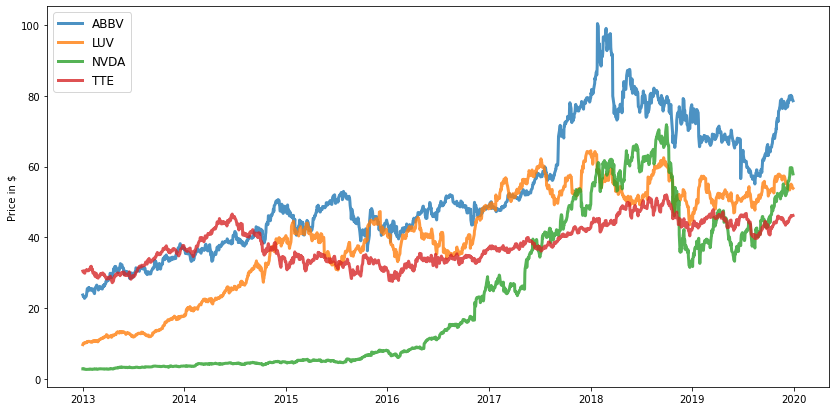

In [6]:
plt.figure(figsize=(14,7))

for c in table.columns.values:
    plt.plot(table.index, table[c],lw=3,alpha=0.8,label=c)

plt.legend(loc='upper left',fontsize=12)
plt.ylabel('Price in $')

<a id='ratios'></a>
### Financial Ratios

In [7]:
df = table.pct_change().dropna()

In [8]:
df.head()

,ABBV,LUV,NVDA,TTE
Date,,,,
2013-01-03,-0.008257,0.023878,0.000786,-0.007418
2013-01-04,-0.012633,0.014926,0.032993,0.002491
2013-01-07,0.002036,0.002757,-0.028897,-0.011852
2013-01-08,-0.021764,0.010999,-0.021927,-0.002128
2013-01-09,0.005636,-0.002720,-0.022418,-0.000582


In [9]:
def sharpe_ratio(return_series,N,rf):
    mean=return_series.mean()*N-rf
    sigma=return_series.std()*np.sqrt(N)
    return mean/sigma

sharpes = df.apply(sharpe_ratio,args=(N,rf),axis=0)


In [10]:
def sortino_ratio(series,N,rf):
    mean=series.mean()*N-rf
    std_neg=series[series<0].std()*np.sqrt(N)
    return mean/std_neg

sortinos = df.apply(sortino_ratio,args=(N,rf,),axis=0)


In [11]:
def max_drawdown(return_series):
    comp_ret=(return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

max_drawdowns = df.apply(max_drawdown,axis=0)


In [12]:
calmars =df.mean()*N/abs(max_drawdowns)

In [13]:
pd.DataFrame([sharpes, sortinos, max_drawdowns, calmars],
             index=['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'])

,ABBV,LUV,NVDA,TTE
Sharpe Ratio,0.736370,1.017232,1.292505,0.345550
Sortino Ratio,0.945319,1.400369,1.822800,0.492753
Max Drawdown,-0.450898,-0.322948,-0.560384,-0.407697
Calmar Ratio,0.469026,0.880037,0.901361,0.206709


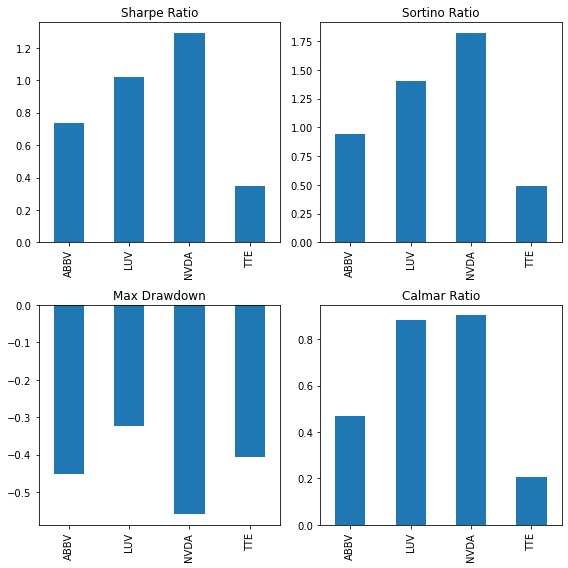

In [14]:
fig = plt.figure(figsize = [8,8])

plt.subplot(2, 2, 1)
plt.title('Sharpe Ratio')
sharpes.plot.bar()

plt.subplot(2, 2, 2)
plt.title('Sortino Ratio')
sortinos.plot.bar()

plt.subplot(2, 2, 3)
plt.title('Max Drawdown')
max_drawdowns.plot.bar()

plt.subplot(2, 2, 4)
plt.title('Calmar Ratio')
calmars.plot.bar()

fig.tight_layout()
plt.show()

<a id='corr'></a>
### Correlation and Covariance

In [15]:
corrstartdate = datetime(2019,1,1)

A shorter timeframe is used for the correlation analysis. A longer timeframe will show strong positive correlations across all stocks since the broad market, including the stocks in this portfolio, increased significantly.

In [16]:
corrtable = pdr.get_data_yahoo(stocks, data_source = 'yahoo', start = corrstartdate, end = enddate)['Adj Close']
corr_df = corrtable.corr(method='pearson')

# Swap symbols as Index
corr_df.head().reset_index()
corr_df.head()

[*********************100%***********************]  4 of 4 completed


,ABBV,LUV,NVDA,TTE
ABBV,1.000000,0.353886,0.508402,0.462153
LUV,0.353886,1.000000,0.571682,0.244620
NVDA,0.508402,0.571682,1.000000,0.259492
TTE,0.462153,0.244620,0.259492,1.000000


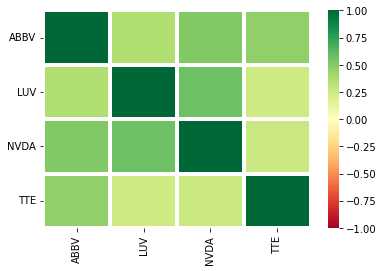

In [17]:
# Correlation Heatmap

seaborn.heatmap(corr_df, cmap='RdYlGn',vmax=1.0,vmin=-1.0,linewidths=2.1)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

<a id='montecarlo'></a>
### Monte Carlo Simulation
<a href='#mcnvda'>NVDA</a> | <a href='#mcabbv'>ABBV</a> | <a href='#mctte'>TTE</a> | <a href='#mcluv'>LUV</a>

<a id='mcnvda'></a>
#### NVDA

In [18]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['NVDA'][-1]) / table['NVDA'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['NVDA Returns'] = table['NVDA'].pct_change()
vol = table['NVDA Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 53.12%
Annual Volatility = 38.21%


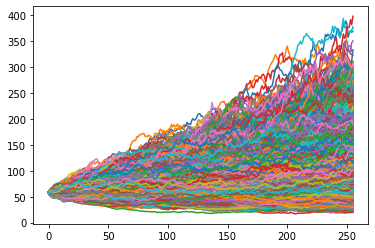

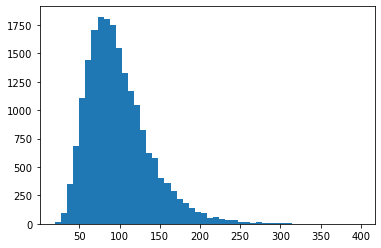

The average price of NVDA stock can be $98.88 in one year.


In [19]:
# Monte Carlo Simulation

result = []

S = table['NVDA'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.5312 #Return
vol = 0.3821 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of NVDA stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<a id='mcabbv'></a>
#### ABBV

In [20]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['ABBV'][-1]) / table['ABBV'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['ABBV Returns'] = table['ABBV'].pct_change()
vol = table['ABBV Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 18.77%
Annual Volatility = 27.43%


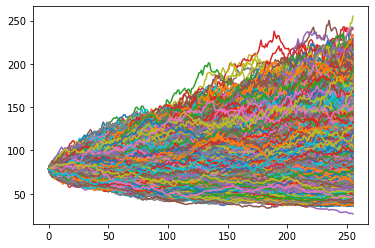

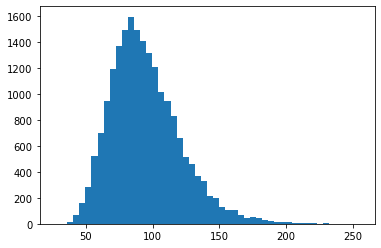

The average price of ABBV stock can be $94.76 in one year.


In [26]:
# Monte Carlo Simulation

result = []

S = table['ABBV'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.1877 #Return
vol = 0.2743 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of ABBV stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<a id='mctte'></a>
#### TTE

In [22]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['TTE'][-1]) / table['TTE'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['TTE Returns'] = table['TTE'].pct_change()
vol = table['TTE Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 6.22%
Annual Volatility = 21.85%


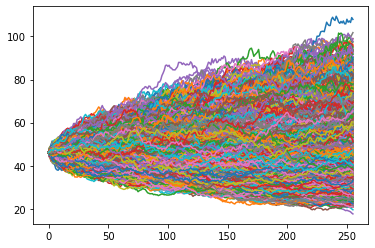

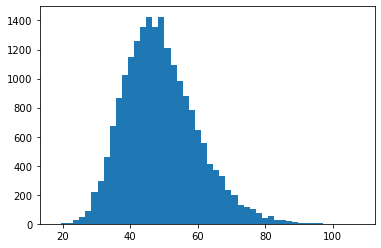

The average price of TTE stock can be $49.08 in one year.


In [23]:
# Monte Carlo Simulation

result = []

S = table['TTE'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.0622 #Return
vol = 0.2185 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of TTE stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<a id='mcluv'></a>
#### LUV

In [24]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['LUV'][-1]) / table['LUV'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['LUV Returns'] = table['LUV'].pct_change()
vol = table['LUV Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 27.200000000000003%
Annual Volatility = 26.96%


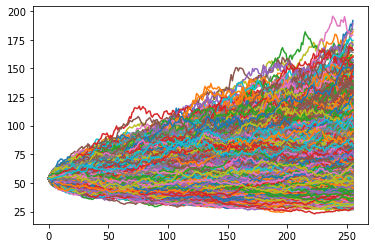

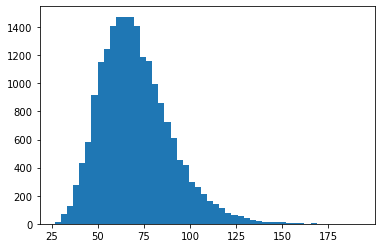

The average price of LUV stock can be $70.57 in one year.


In [25]:
# Monte Carlo Simulation

result = []

S = table['LUV'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.2720 #Return
vol = 0.2696 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of LUV stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<a id='portfolio'></a>
### Portfolio Optimization

In [73]:
table = table[['ABBV', 'LUV', 'NVDA', 'TTE']]

In [74]:
#Next, let's set up our final input variables, calculating the mean returns of each stock, as well as a covariance matrix to be used in our risk calculation below.

returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Number of portfolios to simulate
num_portfolios = 20000

# Risk free rate (used for Sharpe ratio below)
# risk_free_rate = 0.0071

In [75]:
#Random Portfolio Generation

# we'll define functions to assign random weights to each stock in the portfolio, 
# then calculate the portfolio's overall annualized returns and annualized volatility.

#Function to calculate returns, volitality:

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):

     # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

# Next, we can create a function to generate random portfolios with random weights assigned to each equity:
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
     # Array to store the weights of each equity
    weights_record = []
    for i in range(num_portfolios):
          # Randomly assign floats to our 4 equities
        weights = np.random.random(4)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
           # Add to our portfolio weight array
        weights_record.append(weights)
 # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
         # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
         # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [76]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

In [77]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [78]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [79]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [88]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annualised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.23


             ABBV    LUV  NVDA  TTE
allocation  20.37  37.73  41.9  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.18
Annualised Volatility: 0.17


            ABBV    LUV  NVDA    TTE
allocation  22.4  26.68  4.83  46.09
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

ABBV : annualised return 0.21 , annualised volatility: 0.27
LUV : annualised return 0.28 , annualised volatility: 0.27
NVDA : annualised return 0.5 , annualised volatility: 0.38
TTE : annualised return 0.08 , annualised volatility: 0.22
--------------------------------------------------------------------------------


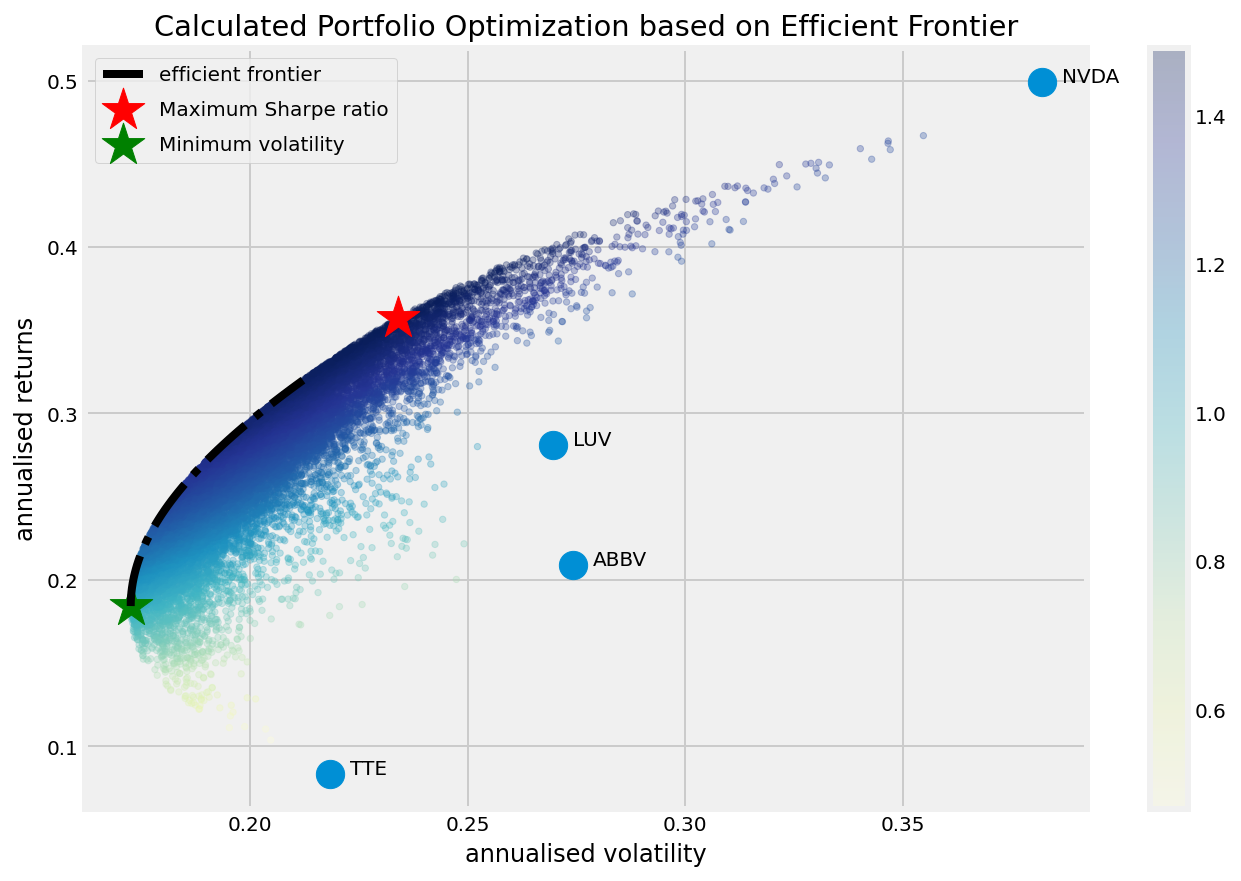

In [89]:
allocation = display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, rf)

<a id='scenario'></a>
### Scenario Analysis

In [105]:
returns = table.pct_change().dropna()

,ABBV,LUV,NVDA,TTE,Portfolio - Max Sharpe,Portfolio - Reallocated
Date,,,,,,
2019-12-30,3.302654,5.508946,19.705162,1.513782,10.031739,7.792498


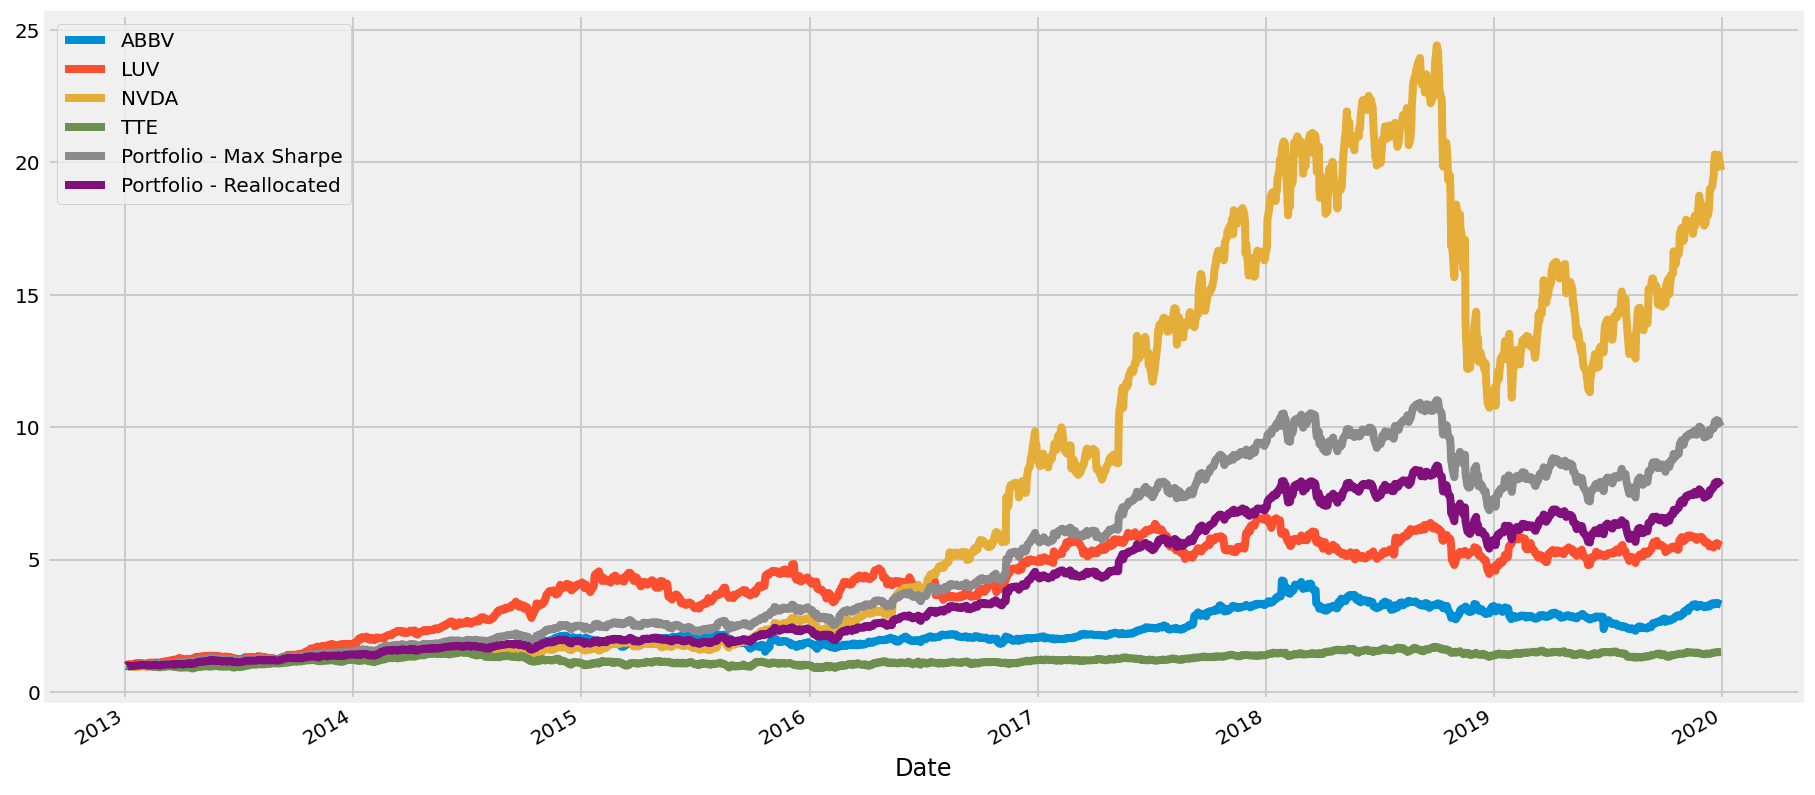

In [102]:
returns['Portfolio - Max Sharpe'] = (returns['ABBV']*.2037) + (returns['LUV']*.3773) + (returns['NVDA']*.419)
returns['Portfolio - Reallocated'] = (returns['ABBV']*.2037) + (returns['LUV']*.1773) + (returns['NVDA']*.419) + (returns['TTE']*.20)
plt.rcParams["figure.figsize"] = (14,7)
(returns+1).cumprod().plot()

(returns+1).cumprod()[-1:]